# MLJ for Data Scientists in Two Hours

An application of the [MLJ
toolbox](https://alan-turing-institute.github.io/MLJ.jl/dev/) to the
Telco Customer Churn dataset, aimed at practicing data scientists
new to MLJ (Machine Learning in Julia). This tutorial does not
cover exploratory data analysis.

MLJ is a *multi-paradigm* machine learning toolbox (i.e., not just
deep-learning).

For other MLJ learning resources see the [Learning
MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_mlj/)
section of the
[manual](https://alan-turing-institute.github.io/MLJ.jl/dev/).

**Topics covered**: Grabbing and preparing a dataset, basic
fit/predict workflow, constructing a pipeline to include data
pre-processing, estimating performance metrics, ROC curves, confusion
matrices, feature importance, basic feature selection, controlling iterative
models, hyper-parameter optimization (tuning).

**Prerequisites for this tutorial.** Previous experience building,
evaluating, and optimizing machine learning models using
scikit-learn, caret, MLR, weka, or similar tool. No previous
experience with MLJ. Only fairly basic familiarity with Julia is
required. Uses
[DataFrames.jl](https://dataframes.juliadata.org/stable/) but in a
minimal way ([this
cheatsheet](https://ahsmart.com/pub/data-wrangling-with-data-frames-jl-cheat-sheet/index.html)
may help).

**Time.** Between two and three hours, first time through.

## Summary of methods and types introduced

|code   | purpose|
|:-------|:-------------------------------------------------------|
|`OpenML.load(id)` | grab a dataset from [OpenML.org](https://www.openml.org)|
|`scitype(X)`      | inspect the scientific type (scitype) of object `X`|
|`schema(X)`       | inspect the column scitypes (scientific types) of a table `X`|
|`coerce(X, ...)`   | fix column encodings to get appropriate scitypes|
|`partition(data, frac1, frac2, ...; rng=...)` | vertically split `data`, which can be a table, vector or matrix|
|`unpack(table, f1, f2, ...)` | horizontally split `table` based on conditions `f1`, `f2`, ..., applied to column names|
|`@load ModelType pkg=...`           | load code defining a model type|
|`input_scitype(model)` | inspect the scitype that a model requires for features (inputs)|
|`target_scitype(model)`| inspect the scitype that a model requires for the target (labels)|
|`ContinuousEncoder`   | built-in model type for re-encoding all features as `Continuous`|# |`model1 |> model2` |> ...` | combine multiple models into a pipeline
| `measures("under curve")` | list all measures (metrics) with string "under curve" in documentation
| `accuracy(yhat, y)` | compute accuracy of predictions `yhat` against ground truth observations `y`
| `auc(yhat, y)`, `brier_loss(yhat, y)` | evaluate two probabilistic measures (`yhat` a vector of probability distributions)
| `machine(model, X, y)` | bind `model` to training data `X` (features) and `y` (target)
| `fit!(mach, rows=...)` | train machine using specified rows (observation indices)
| `predict(mach, rows=...)`, | make in-sample model predictions given specified rows
| `predict(mach, Xnew)` | make predictions given new features `Xnew`
| `fitted_params(mach)` | inspect learned parameters
| `report(mach)`        | inspect other outcomes of training
| `confmat(yhat, y)`    | confusion matrix for predictions `yhat` and ground truth `y`
| `roc(yhat, y)` | compute points on the receiver-operator Characteristic
| `StratifiedCV(nfolds=6)` | 6-fold stratified cross-validation resampling strategy
| `Holdout(fraction_train=0.7)` | holdout resampling strategy
| `evaluate(model, X, y; resampling=..., options...)` | estimate performance metrics `model` using the data `X`, `y`
| `FeatureSelector()` | transformer for selecting features
| `Step(3)` | iteration control for stepping 3 iterations
| `NumberSinceBest(6)`, `TimeLimit(60/5), InvalidValue()` | iteration control stopping criteria
| `IteratedModel(model=..., controls=..., options...)` | wrap an iterative `model` in control strategies
| `range(model,  :some_hyperparam, lower=..., upper=...)` | define a numeric range
| `RandomSearch()` | random search tuning strategy
| `TunedModel(model=..., tuning=..., options...)` | wrap the supervised `model` in specified `tuning` strategy

## Instantiate a Julia environment

The following code replicates precisely the set of Julia packages
used to develop this tutorial. If this is your first time running
the notebook, package instantiation and pre-compilation may take a
minute or so to complete. **This step will fail** if the [correct
Manifest.toml and Project.toml
files](https://github.com/alan-turing-institute/MLJ.jl/tree/dev/examples/telco)
are not in the same directory as this notebook.

In [1]:
using Pkg
Pkg.activate(@__DIR__) # get env from TOML files in same directory as this notebook
Pkg.instantiate()

  Activating environment at `~/GoogleDrive/Julia/MLJ/MLJ/examples/telco/Project.toml`
Precompiling project...
  ✓ Plots
  1 dependency successfully precompiled in 48 seconds (204 already precompiled)


## Warm up: Building a model for the iris dataset

Before turning to the Telco Customer Churn dataset, we very quickly
build a predictive model for Fisher's well-known iris data set, as way of
introducing the main actors in any MLJ workflow. Details that you
don't fully grasp should become clearer in the Telco study.

This section is a condensed adaption of the [Getting Started
example](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Fit-and-predict)
in the MLJ documentation.

First, using the built-in iris dataset, we load and inspect the features
`X_iris` (a table) and target variable `y_iris` (a vector):

In [2]:
using MLJ

In [3]:
const X_iris, y_iris = @load_iris;
schema(X_iris)

┌──────────────┬────────────┬─────────┐
│ names        │ scitypes   │ types   │
├──────────────┼────────────┼─────────┤
│ sepal_length │ Continuous │ Float64 │
│ sepal_width  │ Continuous │ Float64 │
│ petal_length │ Continuous │ Float64 │
│ petal_width  │ Continuous │ Float64 │
└──────────────┴────────────┴─────────┘


In [4]:
y_iris[1:4]

4-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"

In [5]:
levels(y_iris)

3-element Vector{String}:
 "setosa"
 "versicolor"
 "virginica"

We load a decision tree model, from the package DecisionTree.jl:

In [6]:
DecisionTree = @load DecisionTreeClassifier pkg=DecisionTree # model type
model = DecisionTree(min_samples_split=5)                    # model instance

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/38NmP/src/loading.jl:168


import MLJDecisionTreeInterface ✔


DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 5,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    display_depth = 5,
    rng = Random._GLOBAL_RNG())

In MLJ, a *model* is just a container for hyper-parameters of
some learning algorithm. It does not store learned parameters.

Next, we bind the model together with the available data in what's
called a *machine*:

In [7]:
mach = machine(model, X_iris, y_iris)

Machine{DecisionTreeClassifier,…} trained 0 times; caches data
  model: MLJDecisionTreeInterface.DecisionTreeClassifier
  args: 
    1:	Source @355 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @137 ⏎ `AbstractVector{Multiclass{3}}`


A machine is essentially just a model (ie, hyper-parameters) plus data, but
it additionally stores *learned parameters* (the tree) once it is
trained on some view of the data:

In [8]:
train_rows = vcat(1:60, 91:150); # some row indices (observations are rows not columns)
fit!(mach, rows=train_rows)
fitted_params(mach)

┌ Info: Training Machine{DecisionTreeClassifier,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:464


(tree = Decision Tree
Leaves: 5
Depth:  3,
 encoding = Dict{CategoricalArrays.CategoricalValue{String, UInt32}, UInt32}("virginica" => 0x00000003, "setosa" => 0x00000001, "versicolor" => 0x00000002),
 features = [:sepal_length, :sepal_width, :petal_length, :petal_width],)

A machine stores some other information enabling [warm
restart](https://alan-turing-institute.github.io/MLJ.jl/dev/machines/#Warm-restarts)
for some models, but we won't go into that here. You are allowed to
access and mutate the `model` parameter:

In [9]:
mach.model.min_samples_split  = 10
fit!(mach, rows=train_rows) # re-train with new hyper-parameter

┌ Info: Updating Machine{DecisionTreeClassifier,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:465


Machine{DecisionTreeClassifier,…} trained 2 times; caches data
  model: MLJDecisionTreeInterface.DecisionTreeClassifier
  args: 
    1:	Source @355 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @137 ⏎ `AbstractVector{Multiclass{3}}`


Now we can make predictions on some other view of the data, as in

In [10]:
predict(mach, rows=71:73)

3-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>0.0, virginica=>1.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>1.0, virginica=>0.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>0.25, virginica=>0.75)

or on completely new data, as in

In [11]:
Xnew = (sepal_length = [5.1, 6.3],
        sepal_width = [3.0, 2.5],
        petal_length = [1.4, 4.9],
        petal_width = [0.3, 1.5])
yhat = predict(mach, Xnew)

2-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(setosa=>1.0, versicolor=>0.0, virginica=>0.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>0.25, virginica=>0.75)

These are probabilistic predictions which can be manipulated using a
widely adopted interface defined in the Distributions.jl
package. For example, we can get raw probabilities like this:

In [12]:
pdf.(yhat, "virginica")

2-element Vector{Float64}:
 0.0
 0.75

We now turn to the Telco dataset.

## Getting the Telco data

In [13]:
import DataFrames

In [14]:
data = OpenML.load(42178) # data set from OpenML.org
df0 = DataFrames.DataFrame(data)
first(df0, 4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines
,String,String,Float64,String,String,Float64,String,String
1,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service
2,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No
3,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No
4,7795-CFOCW,Male,0.0,No,No,45.0,No,No phone service


The object of this tutorial is to build and evaluate supervised
learning models to predict the `:Churn` variable, a binary variable
measuring customer retention, based on other variables that are
relevant.

In the table, observations correspond to rows, and features to
columns, which is the convention for representing all
two-dimensional data in MLJ.

## Type coercion

> Introduces: `scitype`, `schema`, `coerce`

A ["scientific
type"](https://juliaai.github.io/ScientificTypes.jl/dev/) or
*scitype* indicates how MLJ will *interpret* data. For example,
`typeof(3.14) == Float64`, while `scitype(3.14) == Continuous` and
also `scitype(3.14f0) == Continuous`. In MLJ, model data
requirements are articulated using scitypes.

Here are common "scalar" scitypes:

![](assets/scitypes.png)

There are also container scitypes. For example, the scitype of any
`N`-dimensional array is `AbstractArray{S, N}`, where `S` is the scitype of the
elements:

In [15]:
scitype(["cat", "mouse", "dog"])

AbstractVector{Textual} (alias for AbstractArray{Textual, 1})

The `schema` operator summarizes the column scitypes of a table:

In [16]:
schema(df0) |> DataFrames.DataFrame  # converted to DataFrame for better display

,names,scitypes,types
,Symbol,DataType,DataType
1,customerID,Textual,String
2,gender,Textual,String
3,SeniorCitizen,Continuous,Float64
4,Partner,Textual,String
5,Dependents,Textual,String
6,tenure,Continuous,Float64
7,PhoneService,Textual,String
8,MultipleLines,Textual,String
9,InternetService,Textual,String


All of the fields being interpreted as `Textual` are really
something else, either `Multiclass` or, in the case of
`:TotalCharges`, `Continuous`. In fact, `:TotalCharges` is
mostly floats wrapped as strings. However, it needs special
treatment because some elements consist of a single space, " ",
which we'll treat as "0.0".

In [17]:
fix_blanks(v) = map(v) do x
    if x == " "
        return "0.0"
    else
        return x
    end
end

df0.TotalCharges = fix_blanks(df0.TotalCharges);

Coercing the `:TotalCharges` type to ensure a `Continuous` scitype:

In [18]:
coerce!(df0, :TotalCharges => Continuous);

Coercing all remaining `Textual` data to `Multiclass`:

In [19]:
coerce!(df0, Textual => Multiclass);

Finally, we'll coerce our target variable `:Churn` to be
`OrderedFactor`, rather than `Multiclass`, to enable a reliable
interpretation of metrics like "true positive rate".  By convention,
the first class is the negative one:

In [20]:
coerce!(df0, :Churn => OrderedFactor)
levels(df0.Churn) # to check order

2-element Vector{String}:
 "No"
 "Yes"

Re-inspecting the scitypes:

In [21]:
schema(df0) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,customerID,Multiclass{7043},"CategoricalValue{String, UInt32}"
2,gender,Multiclass{2},"CategoricalValue{String, UInt32}"
3,SeniorCitizen,Continuous,Float64
4,Partner,Multiclass{2},"CategoricalValue{String, UInt32}"
5,Dependents,Multiclass{2},"CategoricalValue{String, UInt32}"
6,tenure,Continuous,Float64
7,PhoneService,Multiclass{2},"CategoricalValue{String, UInt32}"
8,MultipleLines,Multiclass{3},"CategoricalValue{String, UInt32}"
9,InternetService,Multiclass{3},"CategoricalValue{String, UInt32}"


## Preparing a holdout set for final testing

> Introduces: `partition`

To reduce training times for the purposes of this tutorial, we're
going to dump 90% of observations (after shuffling) and split off
30% of the remainder for use as a lock-and-throw-away-the-key
holdout set:

In [22]:
df, df_test, df_dumped = partition(df0, 0.07, 0.03, # in ratios 7:3:90
                                   stratify=df0.Churn,
                                   rng=123);

The reader interested in including all data can instead do
`df, df_test = partition(df0, 0.7, rng=123)`.

## Splitting data into target and features

> Introduces: `unpack`

In the following call, the column with name `:Churn` is copied over
to a vector `y`, and every remaining column, except `:customerID`
(which contains no useful information) goes into a table `X`. Here
`:Churn` is the target variable for which we seek predictions, given
new versions of the features `X`.

In [23]:
const y, X = unpack(df, ==(:Churn), !=(:customerID));
schema(X).names

(:gender, :SeniorCitizen, :Partner, :Dependents, :tenure, :PhoneService, :MultipleLines, :InternetService, :OnlineSecurity, :OnlineBackup, :DeviceProtection, :TechSupport, :StreamingTV, :StreamingMovies, :Contract, :PaperlessBilling, :PaymentMethod, :MonthlyCharges, :TotalCharges)

In [24]:
intersect([:Churn, :customerID], schema(X).names)

Symbol[]

We'll do the same for the holdout data:

In [25]:
const ytest, Xtest = unpack(df_test, ==(:Churn), !=(:customerID));

## Loading a model and checking type requirements

> Introduces: `@load`, `input_scitype`, `target_scitype`

For tools helping us to identify suitable models, see the [Model
Search](https://alan-turing-institute.github.io/MLJ.jl/dev/model_search/#model_search)
section of the manual. We will build a gradient tree-boosting model,
a popular first choice for structured data like we have here. Model
code is contained in a third-party package called
[EvoTrees.jl](https://github.com/Evovest/EvoTrees.jl) which is
loaded as follows:

In [26]:
Booster = @load EvoTreeClassifier pkg=EvoTrees

import EvoTrees

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/38NmP/src/loading.jl:168


 ✔


EvoTrees.EvoTreeClassifier

Recall that a *model* is just a container for some algorithm's
hyper-parameters. Let's create a `Booster` with default values for
the hyper-parameters:

In [27]:
booster = Booster()

EvoTreeClassifier(
    loss = EvoTrees.Softmax(),
    nrounds = 10,
    λ = 0.0,
    γ = 0.0,
    η = 0.1,
    max_depth = 5,
    min_weight = 1.0,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 64,
    α = 0.5,
    metric = :mlogloss,
    rng = MersenneTwister(123),
    device = "cpu")

This model is appropriate for the kind of target variable we have because of
the following passing test:

In [28]:
scitype(y) <: target_scitype(booster)

true

However, our features `X` cannot be directly used with `booster`:

In [29]:
scitype(X) <: input_scitype(booster)

false

As it turns out, this is because `booster`, like the majority of MLJ
supervised models, expects the features to be `Continuous`. (With
some experience, this can be gleaned from `input_scitype(booster)`.)
So we need categorical feature encoding, discussed next.

## Building a model pipeline to incorporate feature encoding

> Introduces: `ContinuousEncoder`, pipeline operator `|>`

The built-in `ContinuousEncoder` model transforms an arbitrary table
to a table whose features are all `Continuous` (dropping any fields
it does not know how to encode). In particular, all `Multiclass`
features are one-hot encoded.

A *pipeline* is a stand-alone model that internally combines one or
more models in a linear (non-branching) pipeline. Here's a pipeline
that adds the `ContinuousEncoder` as a pre-processor to the
gradient tree-boosting model above:

In [30]:
pipe = ContinuousEncoder() |> booster

ProbabilisticPipeline(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    evo_tree_classifier = EvoTreeClassifier(
            loss = EvoTrees.Softmax(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mlogloss,
            rng = MersenneTwister(123),
            device = "cpu"),
    cache = true)

Note that the component models appear as hyper-parameters of
`pipe`. Pipelines are an implementation of a more general [model
composition](https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/#Composing-Models)
interface provided by MLJ that advanced users may want to learn about.

From the above display, we see that component model hyper-parameters
are now *nested*, but they are still accessible (important in hyper-parameter
optimization):

In [31]:
pipe.evo_tree_classifier.max_depth

5

## Evaluating the pipeline model's performance

> Introduces: `measures` (function), **measures:** `brier_loss`, `auc`, `accuracy`;
> `machine`, `fit!`, `predict`, `fitted_params`, `report`, `roc`, **resampling strategy** `StratifiedCV`, `evaluate`, `FeatureSelector`

Without touching our test set `Xtest`, `ytest`, we will estimate the
performance of our pipeline model, with default hyper-parameters, in
two different ways:

**Evaluating by hand.** First, we'll do this "by hand" using the `fit!` and `predict`
workflow illustrated for the iris data set above, using a
holdout resampling strategy. At the same time we'll see how to
generate a **confusion matrix**, **ROC curve**, and inspect
**feature importances**.

**Automated performance evaluation.** Next we'll apply the more
typical and convenient `evaluate` workflow, but using `StratifiedCV`
(stratified cross-validation) which is more informative.

In any case, we need to choose some measures (metrics) to quantify
the performance of our model. For a complete list of measures, one
does `measures()`. Or we also can do:

In [32]:
measures("Brier")

2-element Vector{NamedTuple{(:name, :instances, :human_name, :target_scitype, :supports_weights, :supports_class_weights, :prediction_type, :orientation, :reports_each_observation, :aggregation, :is_feature_dependent, :docstring, :distribution_type), T} where T<:Tuple}:
 (name = BrierLoss, instances = [brier_loss], ...)
 (name = BrierScore, instances = [brier_score], ...)

We will be primarily using `brier_loss`, but also `auc` (area under
the ROC curve) and `accuracy`.

### Evaluating by hand (with a holdout set)

Our pipeline model can be trained just like the decision tree model
we built for the iris data set. Binding all non-test data to the
pipeline model:

In [33]:
mach_pipe = machine(pipe, X, y)

Machine{ProbabilisticPipeline{NamedTuple{,…},…},…} trained 0 times; caches data
  model: MLJBase.ProbabilisticPipeline{NamedTuple{(:continuous_encoder, :evo_tree_classifier), Tuple{Unsupervised, Probabilistic}}, MLJModelInterface.predict}
  args: 
    1:	Source @100 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{4}}, AbstractVector{Multiclass{3}}}}`
    2:	Source @049 ⏎ `AbstractVector{OrderedFactor{2}}`


We already encountered the `partition` method above. Here we apply
it to row indices, instead of data containers, as `fit!` and
`predict` only need a *view* of the data to work.

In [34]:
train, validation = partition(1:length(y), 0.7)
fit!(mach_pipe, rows=train)

┌ Info: Training Machine{ProbabilisticPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:464
┌ Info: Training Machine{ContinuousEncoder,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:464
┌ Info: Training Machine{EvoTreeClassifier{Float64,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:464


Machine{ProbabilisticPipeline{NamedTuple{,…},…},…} trained 1 time; caches data
  model: MLJBase.ProbabilisticPipeline{NamedTuple{(:continuous_encoder, :evo_tree_classifier), Tuple{Unsupervised, Probabilistic}}, MLJModelInterface.predict}
  args: 
    1:	Source @100 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{4}}, AbstractVector{Multiclass{3}}}}`
    2:	Source @049 ⏎ `AbstractVector{OrderedFactor{2}}`


We note in passing that we can access two kinds of information from a trained machine:

- The **learned parameters** (eg, coefficients of a linear model): We use `fitted_params(mach_pipe)`
- Other **by-products of training** (eg, feature importances): We use `report(mach_pipe)`

In [35]:
fp = fitted_params(mach_pipe);
keys(fp)

(:evo_tree_classifier, :continuous_encoder, :machines, :fitted_params_given_machine)

For example, we can check that the encoder did not actually drop any features:

In [36]:
Set(fp.continuous_encoder.features_to_keep) == Set(schema(X).names)

true

And, from the report, extract feature importances:

In [37]:
rpt = report(mach_pipe)
keys(rpt.evo_tree_classifier)

(:feature_importances,)

In [38]:
fi = rpt.evo_tree_classifier.feature_importances
feature_importance_table =
    (feature=Symbol.(first.(fi)), importance=last.(fi)) |> DataFrames.DataFrame

,feature,importance
,Symbol,Float64
1,tenure,0.339006
2,MonthlyCharges,0.179065
3,Contract__Month-to-month,0.143517
4,TotalCharges,0.0808519
5,PaymentMethod__Bank transfer (automatic),0.0332562
6,SeniorCitizen,0.0327449
7,TechSupport__No,0.0301126
8,PaperlessBilling__No,0.0271853
9,StreamingMovies__Yes,0.0182164


For models not reporting feature importances, we recommend the
[Shapley.jl](https://expandingman.gitlab.io/Shapley.jl/) package.

Returning to predictions and evaluations of our measures:

In [39]:
ŷ = predict(mach_pipe, rows=validation);
@info("Measurements",
      brier_loss(ŷ, y[validation]) |> mean,
      auc(ŷ, y[validation]),
      accuracy(mode.(ŷ), y[validation])
      )

┌ Info: Measurements
│   brier_loss(ŷ, y[validation]) |> mean = 0.2700436048904324
│   auc(ŷ, y[validation]) = 0.8350461133069829
│   accuracy(mode.(ŷ), y[validation]) = 0.8108108108108107
└ @ Main In[39]:2


Note that we need `mode` in the last case because `accuracy` expects
point predictions, not probabilistic ones. (One can alternatively
use `predict_mode` to generate the predictions.)

While we're here, lets also generate a **confusion matrix** and
[receiver-operator
characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
(ROC):

In [40]:
confmat(mode.(ŷ), y[validation])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     No      │     Yes     │
├─────────────┼─────────────┼─────────────┤
│     No      │     101     │     14      │
├─────────────┼─────────────┼─────────────┤
│     Yes     │     14      │     19      │
└─────────────┴─────────────┴─────────────┘


Note: Importing the plotting package and calling the plotting
functions for the first time can take a minute or so.

In [41]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


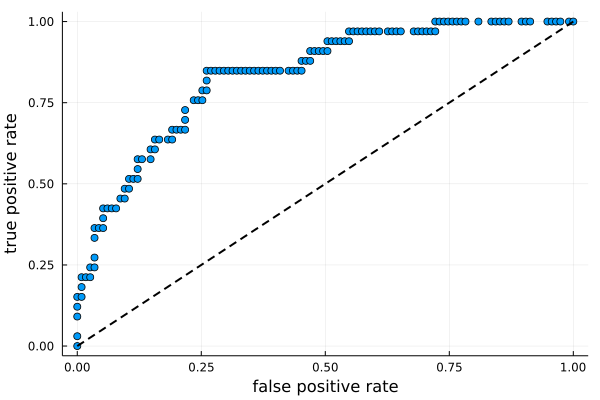

In [42]:
roc_curve = roc(ŷ, y[validation])
plt = scatter(roc_curve, legend=false)
plot!(plt, xlab="false positive rate", ylab="true positive rate")
plot!([0, 1], [0, 1], linewidth=2, linestyle=:dash, color=:black)

### Automated performance evaluation (more typical workflow)

We can also get performance estimates with a single call to the
`evaluate` function, which also allows for more complicated
resampling - in this case stratified cross-validation. To make this
more comprehensive, we set `repeats=3` below to make our
cross-validation "Monte Carlo" (3 random size-6 partitions of the
observation space, for a total of 18 folds) and set
`acceleration=CPUThreads()` to parallelize the computation.

We choose a `StratifiedCV` resampling strategy; the complete list of options is
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/evaluating_model_performance/#Built-in-resampling-strategies).

In [43]:
e_pipe = evaluate(pipe, X, y,
                  resampling=StratifiedCV(nfolds=6, rng=123),
                  measures=[brier_loss, auc, accuracy],
                  repeats=3,
                  acceleration=CPUThreads())

┌ Info: Performing evaluations using 5 threads.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/resampling.jl:1177
Evaluating over 18 folds: 100%[=========================] Time: 0:00:03


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌──────────────────┬─────────────┬──────────────┬───────────────────────────────
│ measure          │ measurement │ operation    │ per_fold                     ⋯
├──────────────────┼─────────────┼──────────────┼───────────────────────────────
│ BrierLoss()      │ 0.313       │ predict      │ [0.296, 0.346, 0.289, 0.337, ⋯
│ AreaUnderCurve() │ 0.789       │ predict      │ [0.791, 0.732, 0.8, 0.778, 0 ⋯
│ Accuracy()       │ 0.781       │ predict_mode │ [0.795, 0.78, 0.768, 0.744,  ⋯
└──────────────────┴─────────────┴──────────────┴───────────────────────────────
                                                                1 column omitted


(There is also a version of `evaluate` for machines. Query the
`evaluate` and `evaluate!` doc-strings to learn more about these
functions and what the `PerformanceEvaluation` object `e_pipe` records.)

While [less than ideal](https://arxiv.org/abs/2104.00673), let's
adopt the common practice of using the standard error of a
cross-validation score as an estimate of the uncertainty of a
performance measure's expected value. Here's a utility function to
calculate confidence intervals for our performance estimates based
on this practice, and it's application to the current evaluation:

In [44]:
using Measurements

In [45]:
function confidence_intervals(e)
    measure = e.measure
    nfolds = length(e.per_fold[1])
    measurement = [e.measurement[j] ± std(e.per_fold[j])/sqrt(nfolds - 1)
                   for j in eachindex(measure)]
    table = (measure=measure, measurement=measurement)
    return DataFrames.DataFrame(table)
end

const confidence_intervals_basic_model = confidence_intervals(e_pipe)

,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.3131±0.0071
2,AreaUnderCurve(),0.789±0.011
3,Accuracy(),0.7809±0.0072


## Filtering out unimportant features

> Introduces: `FeatureSelector`

Before continuing, we'll modify our pipeline to drop those features
with low feature importance, to speed up later optimization:

In [46]:
unimportant_features = filter(:importance => <(0.005), feature_importance_table).feature

pipe2 = ContinuousEncoder() |>
    FeatureSelector(features=unimportant_features, ignore=true) |> booster

ProbabilisticPipeline(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    feature_selector = FeatureSelector(
            features = [:OnlineBackup__No, :Partner__No, Symbol("Contract__Two year"), Symbol("Contract__One year"), :gender__Male, :InternetService__DSL, Symbol("OnlineSecurity__No internet service"), Symbol("PaymentMethod__Mailed check"), Symbol("PaymentMethod__Electronic check"), :OnlineSecurity__Yes  …  :PhoneService__Yes, Symbol("DeviceProtection__No internet service"), Symbol("StreamingTV__No internet service"), Symbol("StreamingMovies__No internet service"), Symbol("TechSupport__No internet service"), :StreamingTV__No, :MultipleLines__No, Symbol("PaymentMethod__Credit card (automatic)"), :MultipleLines__Yes, Symbol("MultipleLines__No phone service")],
            ignore = true),
    evo_tree_classifier = EvoTreeClassifier(
            loss = EvoTrees.Softmax(),
            nrounds = 10,
           

## Wrapping our iterative model in control strategies

> Introduces: **control strategies:** `Step`, `NumberSinceBest`, `TimeLimit`, `InvalidValue`, **model wrapper** `IteratedModel`, **resampling strategy:** `Holdout`

We want to optimize the hyper-parameters of our model. Since our
model is iterative, these parameters include the (nested) iteration
parameter `pipe.evo_tree_classifier.nrounds`. Sometimes this
parameter is optimized first, fixed, and then maybe optimized again
after the other parameters. Here we take a more principled approach,
**wrapping our model in a control strategy** that makes it
"self-iterating". The strategy applies a stopping criterion to
*out-of-sample* estimates of the model performance, constructed
using an internally constructed holdout set. In this way, we avoid
some data hygiene issues, and, when we subsequently optimize other
parameters, we will always being using an optimal number of
iterations.

Note that this approach can be applied to any iterative MLJ model,
eg, the neural network models provided by
[MLJFlux.jl](https://github.com/FluxML/MLJFlux.jl).

First, we select appropriate controls from [this
list](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/#Controls-provided):

In [47]:
controls = [
    Step(1),              # to increment iteration parameter (`pipe.nrounds`)
    NumberSinceBest(4),   # main stopping criterion
    TimeLimit(2/3600),    # never train more than 2 sec
    InvalidValue()        # stop if NaN or ±Inf encountered
]

4-element Vector{Any}:
 Step(1)
 NumberSinceBest(4)
 TimeLimit(Dates.Millisecond(2000))
 InvalidValue()

Now we wrap our pipeline model using the `IteratedModel` wrapper,
being sure to specify the `measure` on which internal estimates of
the out-of-sample performance will be based:

In [48]:
iterated_pipe = IteratedModel(model=pipe2,
                              controls=controls,
                              measure=brier_loss,
                              resampling=Holdout(fraction_train=0.7))

ProbabilisticIteratedModel(
    model = ProbabilisticPipeline(
            continuous_encoder = ContinuousEncoder,
            feature_selector = FeatureSelector,
            evo_tree_classifier = EvoTreeClassifier{Float64,…},
            cache = true),
    controls = Any[Step(1), NumberSinceBest(4), TimeLimit(Dates.Millisecond(2000)), InvalidValue()],
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = BrierLoss(),
    weights = nothing,
    class_weights = nothing,
    operation = MLJModelInterface.predict,
    retrain = false,
    check_measure = true,
    iteration_parameter = nothing,
    cache = true)

We've set `resampling=Holdout(fraction_train=0.7)` to arrange that
data attached to our model should be internally split into a train
set (70%) and a holdout set (30%) for determining the out-of-sample
estimate of the Brier loss.

For demonstration purposes, let's bind `iterated_model` to all data
not in our don't-touch holdout set, and train on all of that data:

In [49]:
mach_iterated_pipe = machine(iterated_pipe, X, y)
fit!(mach_iterated_pipe);

┌ Info: Training Machine{ProbabilisticIteratedModel{ProbabilisticPipeline{NamedTuple{,…},…}},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:464
┌ Info: No iteration parameter specified. Using `iteration_parameter=:(evo_tree_classifier.nrounds)`. 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/LXjxi/src/core.jl:62
┌ Info: final loss: 0.2630163172395482
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/train.jl:44
┌ Info: Stop triggered by NumberSinceBest(4) stopping criterion. 
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/lO4bA/src/stopping_controls.jl:54
┌ Info: Total of 24 iterations. 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/LXjxi/src/core.jl:35


To recap, internally this training is split into two separate steps:

- A controlled iteration step, training on the holdout set, with the total number of iterations determined by the specified stopping criteria (based on the out-of-sample performance estimates)
- A final step that trains the atomic model on *all* available
  data using the number of iterations determined in the first step. Calling `predict` on `mach_iterated_pipe` means using the learned parameters of the second step.

## Hyper-parameter optimization (model tuning)

> Introduces: `range`, **model wrapper** `TunedModel`, `RandomSearch`

We now turn to hyper-parameter optimization. A tool not discussed
here is the `learning_curve` function, which can be useful when
wanting to visualize the effect of changes to a *single*
hyper-parameter (which could be an iteration parameter). See, for
example, [this section of the
manual](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_curves/)
or [this
tutorial](https://github.com/ablaom/MLJTutorial.jl/blob/dev/notebooks/04_tuning/notebook.ipynb).

Fine tuning the hyper-parameters of a gradient booster can be
somewhat involved. Here we settle for simultaneously optimizing two
key parameters: `max_depth` and `η` (learning_rate).

Like iteration control, **model optimization in MLJ is implemented as
a model wrapper**, called `TunedModel`. After wrapping a model in a
tuning strategy and binding the wrapped model to data in a machine
called `mach`, calling `fit!(mach)` instigates a search for optimal
model hyperparameters, within a specified range, and then uses all
supplied data to train the best model. To predict using that model,
one then calls `predict(mach, Xnew)`. In this way the wrapped model
may be viewed as a "self-tuning" version of the unwrapped
model. That is, wrapping the model simply transforms certain
hyper-parameters into learned parameters (just as `IteratedModel`
does for an iteration parameter).

To start with, we define ranges for the parameters of
interest. Since these parameters are nested, let's force a
display of our model to a larger depth:

In [50]:
show(iterated_pipe, 2)

ProbabilisticIteratedModel(
    model = ProbabilisticPipeline(
            continuous_encoder = ContinuousEncoder(
                    drop_last = false,
                    one_hot_ordered_factors = false),
            feature_selector = FeatureSelector(
                    features = [:OnlineBackup__No, :Partner__No, Symbol("Contract__Two year"), Symbol("Contract__One year"), :gender__Male, :InternetService__DSL, Symbol("OnlineSecurity__No internet service"), Symbol("PaymentMethod__Mailed check"), Symbol("PaymentMethod__Electronic check"), :OnlineSecurity__Yes, Symbol("InternetService__Fiber optic"), Symbol("OnlineBackup__No internet service"), :InternetService__No, :StreamingTV__Yes, :PhoneService__No, :PhoneService__Yes, Symbol("DeviceProtection__No internet service"), Symbol("StreamingTV__No internet service"), Symbol("StreamingMovies__No internet service"), Symbol("TechSupport__No internet service"), :StreamingTV__No, :MultipleLines__No, Symbol("PaymentMethod__Credit card (automa

In [51]:
p1 = :(model.evo_tree_classifier.η)
p2 = :(model.evo_tree_classifier.max_depth)

r1 = range(iterated_pipe, p1, lower=-2, upper=-0.5, scale=x->10^x)
r2 = range(iterated_pipe, p2, lower=2, upper=6)

NumericRange(2 ≤ model.evo_tree_classifier.max_depth ≤ 6; origin=4.0, unit=2.0)

Nominal ranges are defined by specifying `values` instead of `lower`
and `upper`.

Next, we choose an optimization strategy from [this
list](https://alan-turing-institute.github.io/MLJ.jl/dev/tuning_models/#Tuning-Models):

In [52]:
tuning = RandomSearch(rng=123)

RandomSearch(
    bounded = Distributions.Uniform,
    positive_unbounded = Distributions.Gamma,
    other = Distributions.Normal,
    rng = MersenneTwister(123))

Then we wrap the model, specifying a `resampling` strategy and a
`measure`, as we did for `IteratedModel`.  In fact, we can include a
battery of `measures`; by default, optimization is with respect to
performance estimates based on the first measure, but estimates for
all measures can be accessed from the model's `report`.

The keyword `n` specifies the total number of models (sets of
hyper-parameters) to evaluate.

In [53]:
tuned_iterated_pipe = TunedModel(model=iterated_pipe,
                                 range=[r1, r2],
                                 tuning=tuning,
                                 measures=[brier_loss, auc, accuracy],
                                 resampling=StratifiedCV(nfolds=6, rng=123),
                                 acceleration=CPUThreads(),
                                 n=40)

ProbabilisticTunedModel(
    model = ProbabilisticIteratedModel(
            model = ProbabilisticPipeline{NamedTuple{,…},…},
            controls = Any[Step(1), NumberSinceBest(4), TimeLimit(Dates.Millisecond(2000)), InvalidValue()],
            resampling = Holdout,
            measure = BrierLoss(),
            weights = nothing,
            class_weights = nothing,
            operation = MLJModelInterface.predict,
            retrain = false,
            check_measure = true,
            iteration_parameter = nothing,
            cache = true),
    tuning = RandomSearch(
            bounded = Distributions.Uniform,
            positive_unbounded = Distributions.Gamma,
            other = Distributions.Normal,
            rng = MersenneTwister(123)),
    resampling = StratifiedCV(
            nfolds = 6,
            shuffle = true,
            rng = MersenneTwister(123)),
    measure = MLJBase.Measure[BrierLoss(), AreaUnderCurve(), Accuracy()],
    weights = nothing,
    operation 

To save time, we skip the `repeats` here.

Binding our final model to data and training:

In [54]:
mach_tuned_iterated_pipe = machine(tuned_iterated_pipe, X, y)
fit!(mach_tuned_iterated_pipe)

┌ Info: Training Machine{ProbabilisticTunedModel{RandomSearch,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/hHa7b/src/machines.jl:464
┌ Info: Attempting to evaluate 40 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/Al9yX/src/tuned_models.jl:680
Evaluating over 40 metamodels: 100%[=========================] Time: 0:00:42


Machine{ProbabilisticTunedModel{RandomSearch,…},…} trained 1 time; caches data
  model: MLJTuning.ProbabilisticTunedModel{RandomSearch, MLJIteration.ProbabilisticIteratedModel{MLJBase.ProbabilisticPipeline{NamedTuple{(:continuous_encoder, :feature_selector, :evo_tree_classifier), Tuple{Unsupervised, Unsupervised, Probabilistic}}, MLJModelInterface.predict}}}
  args: 
    1:	Source @974 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{4}}, AbstractVector{Multiclass{3}}}}`
    2:	Source @709 ⏎ `AbstractVector{OrderedFactor{2}}`


As explained above, the training we have just performed was split
internally into two separate steps:

- A step to determine the parameter values that optimize the aggregated cross-validation scores
- A final step that trains the optimal model on *all* available data. Future predictions `predict(mach_tuned_iterated_pipe, ...)` are based on this final training step.

From `report(mach_tuned_iterated_pipe)` we can extract details about
the optimization procedure. For example:

In [55]:
rpt2 = report(mach_tuned_iterated_pipe);
best_booster = rpt2.best_model.model.evo_tree_classifier

EvoTreeClassifier(
    loss = EvoTrees.Softmax(),
    nrounds = 10,
    λ = 0.0,
    γ = 0.0,
    η = 0.14682597477521467,
    max_depth = 2,
    min_weight = 1.0,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 64,
    α = 0.5,
    metric = :mlogloss,
    rng = MersenneTwister(123, (0, 86172, 85170, 780)),
    device = "cpu")

In [56]:
@info "Optimal hyper-parameters:" best_booster.max_depth best_booster.η;

┌ Info: Optimal hyper-parameters:
│   best_booster.max_depth = 2
│   best_booster.η = 0.14682597477521467
└ @ Main In[56]:1


Using the `confidence_intervals` function we defined earlier:

In [57]:
e_best = rpt2.best_history_entry
confidence_intervals(e_best)

,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.292±0.017
2,AreaUnderCurve(),0.814±0.028
3,Accuracy(),0.797±0.016


Digging a little deeper, we can learn what stopping criterion was
applied in the case of the optimal model, and how many iterations
were required:

In [58]:
rpt2.best_report.controls |> collect

4-element Vector{Tuple{Any, NamedTuple}}:
 (Step(1), (new_iterations = 26,))
 (NumberSinceBest(4), (done = true, log = "Stop triggered by NumberSinceBest(4) stopping criterion. "))
 (TimeLimit(Dates.Millisecond(2000)), (done = false, log = ""))
 (InvalidValue(), (done = false, log = ""))

Finally, we can visualize the optimization results:

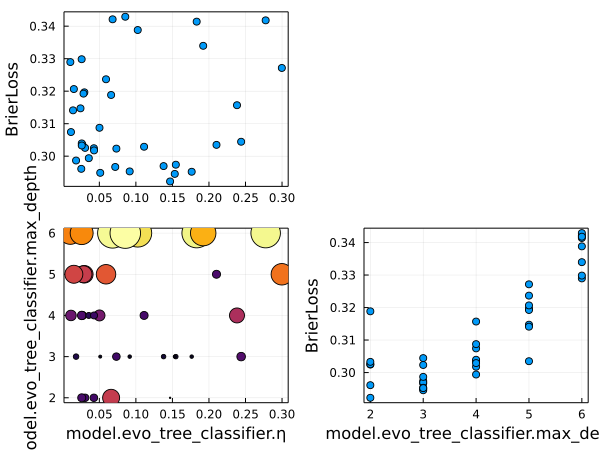

In [59]:
plot(mach_tuned_iterated_pipe, size=(600,450))

## Saving our model

> Introduces: `MLJ.save`

Here's how to serialize our final, trained self-iterating,
self-tuning pipeline machine:

In [60]:
MLJ.save("tuned_iterated_pipe.jlso", mach_tuned_iterated_pipe)

We'll deserialize this in "Testing the final model" below.

## Final performance estimate

Finally, to get an even more accurate estimate of performance, we
can evaluate our model using stratified cross-validation and all the
data attached to our machine. Because this evaluation implies
[nested
resampling](https://mlr.mlr-org.com/articles/tutorial/nested_resampling.html),
this computation takes quite a bit longer than the previous one
(which is being repeated six times, using 5/6th of the data each
time):

In [61]:
e_tuned_iterated_pipe = evaluate(tuned_iterated_pipe, X, y,
                                 resampling=StratifiedCV(nfolds=6, rng=123),
                                 measures=[brier_loss, auc, accuracy])

Evaluating over 6 folds: 100%[=========================] Time: 0:03:51


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌──────────────────┬─────────────┬──────────────┬───────────────────────────────
│ measure          │ measurement │ operation    │ per_fold                     ⋯
├──────────────────┼─────────────┼──────────────┼───────────────────────────────
│ BrierLoss()      │ 0.295       │ predict      │ [0.308, 0.337, 0.265, 0.288, ⋯
│ AreaUnderCurve() │ 0.809       │ predict      │ [0.793, 0.729, 0.82, 0.851,  ⋯
│ Accuracy()       │ 0.791       │ predict_mode │ [0.795, 0.793, 0.805, 0.78,  ⋯
└──────────────────┴─────────────┴──────────────┴───────────────────────────────
                                                                1 column omitted


In [62]:
confidence_intervals(e_tuned_iterated_pipe)

,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.295±0.016
2,AreaUnderCurve(),0.809±0.029
3,Accuracy(),0.7911±0.0064


For comparison, here are the confidence intervals for the basic
pipeline model (no feature selection and default hyperparameters):

In [63]:
confidence_intervals_basic_model

,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.3131±0.0071
2,AreaUnderCurve(),0.789±0.011
3,Accuracy(),0.7809±0.0072


As each pair of intervals overlap, it's doubtful the small changes
here can be assigned statistical significance. Default `booster`
hyper-parameters do a pretty good job.

## Testing the final model

We now determine the performance of our model on our
lock-and-throw-away-the-key holdout set. To demonstrate
deserialization, we'll pretend we're in a new Julia session (but
have called `import`/`using` on the same packages). Then the
following should suffice to recover our model trained under
"Hyper-parameter optimization" above:

In [64]:
mach_restored = machine("tuned_iterated_pipe.jlso")

Machine{ProbabilisticTunedModel{RandomSearch,…},…} trained 1 time; caches data
  model: MLJTuning.ProbabilisticTunedModel{RandomSearch, MLJIteration.ProbabilisticIteratedModel{MLJBase.ProbabilisticPipeline{NamedTuple{(:continuous_encoder, :feature_selector, :evo_tree_classifier), Tuple{Unsupervised, Unsupervised, Probabilistic}}, MLJModelInterface.predict}}}
  args: 


We compute predictions on the holdout set:

In [65]:
ŷ_tuned = predict(mach_restored, Xtest);
ŷ_tuned[1]

             UnivariateFinite{Multiclass{2}}      
       ┌                                        ┐ 
    No ┤■■■■■■■■■■■■■■■■■ 0.45987161928543624     
   Yes ┤■■■■■■■■■■■■■■■■■■■■ 0.5401283807145638   
       └                                        ┘ 

And can compute the final performance measures:

In [66]:
@info("Tuned model measurements on test:",
      brier_loss(ŷ_tuned, ytest) |> mean,
      auc(ŷ_tuned, ytest),
      accuracy(mode.(ŷ_tuned), ytest)
      )

┌ Info: Tuned model measurements on test:
│   brier_loss(ŷ_tuned, ytest) |> mean = 0.26876013030554674
│   auc(ŷ_tuned, ytest) = 0.8494239631336405
│   accuracy(mode.(ŷ_tuned), ytest) = 0.8104265402843602
└ @ Main In[66]:1


For comparison, here's the performance for the basic pipeline model

In [67]:
mach_basic = machine(pipe, X, y)
fit!(mach_basic, verbosity=0)

ŷ_basic = predict(mach_basic, Xtest);

@info("Basic model measurements on test set:",
      brier_loss(ŷ_basic, ytest) |> mean,
      auc(ŷ_basic, ytest),
      accuracy(mode.(ŷ_basic), ytest)
      )

┌ Info: Basic model measurements on test set:
│   brier_loss(ŷ_basic, ytest) |> mean = 0.2815220182102922
│   auc(ŷ_basic, ytest) = 0.8496543778801844
│   accuracy(mode.(ŷ_basic), ytest) = 0.8009478672985781
└ @ Main In[67]:6


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*